In [17]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from operator import itemgetter
from PIL import Image, ImageOps
import pytesseract
import pyocr
import pyocr.builders
import json
import sys
import os
import glob
import re
import math
import random
import itertools
import sympy as sy
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from shapely.geometry import Polygon

import toda_crop_chars_from_plot as _plot_
import tegaki_error_crop_chars_from_nns as _nns_

In [32]:
if __name__ == "__main__":
    main()

ij_width: 1178, ij_height: 470, [1178, 470]
ij_width: 1133, ij_height: 470, [1178, 470]
ij_width: 45, ij_height: 470, [1178, 470]
hough_lines_p:  179
draw_cross_points: 129
[[[[  10.15   10.  ]
   [  10.15  104.  ]
   [  10.15  198.  ]
   [  10.15  292.  ]
   [  10.15  386.  ]
   [  10.15  480.  ]]]


 [[[  57.45   10.  ]
   [  57.45  104.  ]
   [  57.45  198.  ]
   [  57.45  292.  ]
   [  57.45  386.  ]
   [  57.45  480.  ]]]


 [[[ 151.45   10.  ]
   [ 151.45  104.  ]
   [ 151.45  198.  ]
   [ 151.45  292.  ]
   [ 151.45  386.  ]
   [ 151.45  480.  ]]]


 [[[ 151.45   10.  ]
   [ 151.45  104.  ]
   [ 151.45  198.  ]
   [ 151.45  292.  ]
   [ 151.45  386.  ]
   [ 151.45  480.  ]]]


 [[[ 198.75   10.  ]
   [ 198.75  104.  ]
   [ 198.75  198.  ]
   [ 198.75  292.  ]
   [ 198.75  386.  ]
   [ 198.75  480.  ]]]


 [[[ 292.75   10.  ]
   [ 292.75  104.  ]
   [ 292.75  198.  ]
   [ 292.75  292.  ]
   [ 292.75  386.  ]
   [ 292.75  480.  ]]]


 [[[ 292.75   10.  ]
   [ 292.75  104.  ]
   [ 

In [22]:
def main():
    sheet_path = '../PRMU/simclr/E_sheet'
    save_dir = '../PRMU/simclr/E_char'
    
    char_success_rate = 0.0
    count = 0
    
    for path in glob.glob(f'{sheet_path}/*.png', recursive=True):
        if 'ver2' in path:
            version = '2'
        elif 'ver3' in path:
            version = '3'
        else:
            version = '1'
    
        i = char_from_scan(path, version, save_dir, i = 1)
        
        if i == -1:
            print('crosspoints Detection error')
            i = char_from_scan_old(path, version, save_dir, i = 1)
            
        elif i == 0:
            print('quadrilaterals Detection error')
            Quadfailed.append(path)
        
        else:
            if i is not None:
                char_success_rate += float(i)
                count += 1
            
    print(f"Char Success Rate: '{100 * char_success_rate/count}'%")
    
    #for path, save_dir_imgs in OCRfailed:
    #    print(f'path: {path},\n save_dir: {save_dir_imgs}')
    return i

In [ ]:
import numpy as np
import cv2

IMAGE_PATH = '../PRMU/simclr/E_sheet/fujiwara-PRMU_error_char.png' # grade-3, number-57 % 9
sheet_path = '../PRMU/simclr/E_sheet'

params = {"muki": "tate", "nchars": 5, "ncols": 8, "char_width": 1.2, "sep_width": 0.6}

# ピクセルに変換する
dpi = 200
char_size_px = 94#int((params['char_width'] / 2.54) * dpi)
sep_size_px = 47.3#int((params['sep_width'] / 2.54) * dpi)

save_dir = '../PRMU/simclr/E_char'
file_name = os.path.splitext(os.path.basename(IMAGE_PATH))

def test():
    #image  = cv2.imread(IMAGE_PATH) # 画像読み込み
    #image2 = cv2.imread(IMAGE_PATH) # 画像読み込み

    scan_img = Image.open(IMAGE_PATH)
    cropbox = find_genko_box(scan_img, params)
    print(cropbox)
    l, u, r, b = cropbox
    margin = 10
    cropbox = (l-margin, u-margin, r+margin, b+margin)
    cropped_img = scan_img.crop(cropbox)
    image = np.array(cropped_img)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    #hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    image2 = np.copy(image)

    # マスクを作成
    lower_bound = np.array([0, 0, 128])    
    upper_bound = np.array([50, 50, 255])
    mask = cv2.inRange(image, lower_bound, upper_bound)

    # 赤色領域を抽出
    red_detected = cv2.bitwise_and(image, image, mask=mask)
    canny_edges = cv2.Canny(red_detected, 1, 80, apertureSize = 3)   # 輪郭線抽出
    kernel = np.ones((3, 3), np.uint8)
    outLineImage = cv2.dilate(canny_edges, kernel, iterations=1)
    #outLineImage = cv2.erode(dilated_edges, kernel, iterations=1)

    cv2.imwrite("../PRMU/simclr/outLine.png", outLineImage)    # ファイル保存

    houghPList, mainlines = hough_lines_p(image2, outLineImage, params)  # 確率的ハフ変換による直線抽出
    cv2.imwrite("../PRMU/simclr/result_houghP.png", image2)        # ファイル保存
    cross_points = draw_cross_points(image2, houghPList, params)   # 直線リストから交点を描画
    cv2.imwrite("../PRMU/simclr/result_crosspoint.png", image2)  # ファイル保存

    #---------
    # 原稿用紙の左上を (0, 0) として理想的な交点位置を計算する
    #---------
    model_points = _nns_.make_model_points(params, image)
    #print(model_points)

    # 回転・平行移動補正後の model_points に近いデータ点を選ぶ
    # 行間の 1/5 以上離れたデータ点しかなければ選ばない

    nns = _nns_.find_nns(model_points, model_points, params)#(sep_size_px * 0.2) ** 2)
    #print(nns)
    # cross_pointsに位置付け
    nns = _nns_.reshape(nns, params)
    # cross_pointsノイズ除去、補間
    nns = _nns_.Interpolate_nns(nns)
    nns = remove_rows_with_duplicate_coordinates(nns, decimals=2)

    x = [(1344 - 47.3) - n*(47.3+94) for n in range(8)]
    y = [605 + n*94 for n in range(5)]
    #nns = list(itertools.product(x, y))

    #'''チェックポイント
    try:
        for row in nns:
            #print(row)
            for point in row[0]:
                point = tuple(map(int, point))
                cv2.circle(image2, tuple(point), 5, (0, 0, 255), thickness=2, lineType=cv2.LINE_8, shift=0)
        cv2.imwrite("../PRMU/simclr/selected_nns.jpg", image2)
    except TypeError:
        #char_from_scan_OCRfailed_old(IMAGE_PATH, os.path.join(save_dir, school), f'S{grade}-{number}', i=1)
        print('1')
        #return 0
    #'''

    '''チェックポイント
    for points in sorted_cross_points.values():
        for point in points:
            cv2.circle(image2, tuple(point), 5, (0, 0, 255), thickness=2, lineType=cv2.LINE_8, shift=0)
    cv2.imwrite('/home/abababam1/selected_cross_points.jpg', image2)
    '''

    # cross_pointsからマス目の頂点を検出
    cropboxes = _nns_.cropbox_nns(nns, params)
    print(cropboxes[6])
    for i in range(6,11):
        cropbox = cropboxes[i]
        for point in cropbox:
            point = tuple(map(int, point))
            cv2.circle(image2, tuple(point), 5, (0, 255, 0), thickness=2, lineType=cv2.LINE_8, shift=0)
    cv2.imwrite('../PRMU/simclr/error_points.jpg', image2)
    image = apply_white_mask(image, outLineImage)

    # crop
    cropped_images = _nns_.crop_squares(image, cropboxes)


    # 個々の文字の画像を保存する
    save_path = os.path.join(save_dir, f'{file_name}')
    os.makedirs(save_path, exist_ok=True)
    for i, image in cropped_images.items():
        if image is None or image.size == 0:
            print(i)
            continue
        # 罫線を白塗り
        image = detect_line_in_char(image)
        output_path = f'{save_path}'+'/'+'{:05d}.png'.format(i)
        cv2.imwrite(output_path, image)
        print(f"正方形でクロップされた画像が {output_path} に保存されました")

if __name__ == '__main__':
    test()

In [31]:
def char_from_scan(input_img, version, save_dir, i):
    file_name = os.path.splitext(os.path.basename(input_img))
    
    # スキャン結果を読み込み
    scan_img = Image.open(input_img)
    width, height = scan_img.size
    
    # シート名ごとの原稿配置を取得
    params = {"muki": "tate", "nchars": 5, "ncols": 8, "char_width": 1.2, "sep_width": 0.6}

    # crop_box作成
    cropbox = find_genko_box(scan_img, params)
    if cropbox is None:
        cropbox = find_largest_rectangle(scan_img, params)
        # return 0
    l, u, r, b = cropbox
    margin = 10
    cropbox = (l-margin, u-margin, r+margin, b+margin)
    cropped_img = scan_img.crop(cropbox) # crop の引数は ((left, upper, right, lower))
    
    # pillow to cv2
    image = np.array(cropped_img)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # マスクを作成
    lower_bound = np.array([0, 0, 128])    
    upper_bound = np.array([50, 50, 255])
    mask = cv2.inRange(image, lower_bound, upper_bound)

    # 赤色領域を抽出
    red_detected = cv2.bitwise_and(image, image, mask=mask)
    canny_edges = cv2.Canny(red_detected, 1, 80, apertureSize = 3)   # 輪郭線抽出
    kernel = np.ones((3, 3), np.uint8)
    outLineImage = cv2.dilate(canny_edges, kernel, iterations=1)
    
    houghPList, mainlines = hough_lines_p(image, outLineImage, params)  # 直線抽出
    cross_points = draw_cross_points(image, houghPList, params)   # 直線リストから交点を描画
    cv2.imwrite("../PRMU/simclr/result_houghP_cross.png", image)  # ファイル保存
    
    # 原稿用紙の左上を (0, 0) として理想的な交点位置を計算する
    model_points = _nns_.make_model_points(params, image)
    
    # model_points に近いデータ点を選ぶ
    # 行間の 1/5 以上離れたデータ点しかなければ選ばない
    nns = _nns_.find_nns(model_points, model_points, params)
    
    # cross_pointsに位置付け
    nns = _nns_.reshape(nns, params)
    
    # cross_pointsノイズ除去、補間
    nns = _nns_.Interpolate_nns(nns)
    if nns is None:
        return -1
    nns = remove_rows_with_duplicate_coordinates(nns, decimals=2)
    
    # cross_pointsからマス目の頂点を検出
    cropboxes = _nns_.cropbox_nns(nns, params)
    # crop
    if not cropboxes:
        return 0
    image = apply_white_mask(image, outLineImage)
    cropped_images = _nns_.crop_squares(image, cropboxes)
    
    # 個々の文字の画像を保存する
    save_path = os.path.join(save_dir, version, f'{file_name}')
    os.makedirs(save_path, exist_ok=True)
    for i, image in cropped_images.items():
        if image is None or image.size == 0:
            print(i)
            continue
        # 罫線を白塗り
        image = detect_line_in_char(image)
        output_path = f'{save_path}'+'/'+'{:05d}.png'.format(i)
        cv2.imwrite(output_path, image)
        #print(f"正方形でクロップされた画像が {output_path} に保存されました")
    return i/(params['nchars']*params['ncols'])

In [30]:
def char_from_scan_old(input_img, version, save_dir, i):
    file_name = os.path.splitext(os.path.basename(input_img))
    
    # スキャン結果を読み込み
    scan_img = Image.open(input_img)
    width, height = scan_img.size
    
    # シート名ごとの原稿配置を取得
    params = {"muki": "tate", "nchars": 5, "ncols": 8, "char_width": 1.2, "sep_width": 0.6}
    
    # crop_box作成
    cropbox = find_genko_box(scan_img, params)
    if cropbox is None:
        cropbox = find_largest_rectangle(scan_img, params)
        # return 0
    l, u, r, b = cropbox
    margin = 10
    cropbox = (l-margin, u-margin, r+margin, b+margin)
    cropped_img = scan_img.crop(cropbox) # crop の引数は ((left, upper, right, lower))
    
    # pillow to cv2
    image = np.array(cropped_img)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # マスクを作成
    lower_bound = np.array([0, 0, 128])    
    upper_bound = np.array([50, 50, 255])
    mask = cv2.inRange(image, lower_bound, upper_bound)

    # 赤色領域を抽出
    red_detected = cv2.bitwise_and(image, image, mask=mask)
    canny_edges = cv2.Canny(red_detected, 1, 80, apertureSize = 3)   # 輪郭線抽出
    kernel = np.ones((3, 3), np.uint8)
    outLineImage = cv2.dilate(canny_edges, kernel, iterations=1)
    
    houghPList, mainlines = hough_lines_p(image, outLineImage, params)  # 直線抽出
    cross_points = draw_cross_points(image, houghPList, params)   # 直線リストから交点を描画
    cv2.imwrite("../PRMU/simclr/result_houghP_cross.png", image)  # ファイル保存
    
    # cross_pointsに位置付け
    model_points = _nns_.make_model_points(params, image)
    sorted_cross_points = sort_crosspoints(model_points, params)
    
    # cross_pointsノイズ除去、補間
    sorted_cross_points, minmax = compliment_cross_points(model_points, params, sorted_cross_points)
    
    # cross_pointsからマス目の頂点を検出
    cropboxes = cropboxes_from_cross_points(sorted_cross_points, params, minmax)
    # crop
    if not cropboxes:
        return 0
    image = apply_white_mask(image, outLineImage)
    cropped_images = crop_squares(image, cropboxes)
    
    # 個々の文字の画像を保存する
    save_path = os.path.join(save_dir, version, f'{file_name}')
    os.makedirs(save_path, exist_ok=True)
    for i, image in cropped_images.items():
        if image is None or image.size == 0:
            print(i)
            continue
        # 罫線を白塗り
        image = detect_line_in_char(image)
        output_path = f'{save_path}'+'/'+'{:05d}.png'.format(i)
        cv2.imwrite(output_path, image)
        #print(f"正方形でクロップされた画像が {output_path} に保存されました")
    return i/(params['nchars']*params['ncols'])

In [27]:
def check_genko_size_and_angle(hull, genko_1, genko_2):  
    quad = set()
    n = len(hull)
    x_max, x_min = 0, float('inf')
    y_max, y_min = 0, float('inf')
    genko_angle_list = []
    tate = 0
    yoko = 0
    for i in range(n):
        for j in range(i + 1, n):
            ij_distance = np.linalg.norm(hull[i][0] - hull[j][0])
            ij_width = abs(hull[i][0][0] - hull[j][0][0])
            ij_height = abs(hull[i][0][1] - hull[j][0][1])
            # 横
            if any(abs(ij_distance - henn) <= 50 for henn in [genko_1, genko_2]) and ij_height <= 20:
                yoko = 1
                quad.add(tuple(hull[i][0]))
                quad.add(tuple(hull[j][0]))
                x_max = max(x_max, hull[i][0][0], hull[j][0][0])
                x_min = min(x_min, hull[i][0][0], hull[j][0][0])
                y_max = max(y_max, hull[i][0][1], hull[j][0][1])
                y_min = min(y_min, hull[i][0][1], hull[j][0][1])
                #genko_angle = calculate_angle_yoko(hull[i][0][0], hull[j][0][0], hull[i][0][0], hull[j][0][0])
                #genko_angle_list.append(genko_angle)
            # 縦
            elif ij_width <= 20 and any(abs(ij_distance - henn) <= 50 for henn in [genko_1, genko_2]):
                tate = 1
                quad.add(tuple(hull[i][0]))
                quad.add(tuple(hull[j][0]))
                x_max = max(x_max, hull[i][0][0], hull[j][0][0])
                x_min = min(x_min, hull[i][0][0], hull[j][0][0])
                y_max = max(y_max, hull[i][0][1], hull[j][0][1])
                y_min = min(y_min, hull[i][0][1], hull[j][0][1])
                #genko_angle = calculate_angle_tate(hull[i][0][0], hull[j][0][0], hull[i][0][0], hull[j][0][0])
                #genko_angle_list.append(genko_angle)
            else:
                print(f'ij_width: {ij_width}, ij_height: {ij_height}, {[genko_1, genko_2]}')
    if yoko == 1 and tate == 1:
        # 四頂点と右上の座標
        #cropbox = (max(0, x_min + 5), max(0, y_min + 5), min(x_max - 5, 5000), min(y_max - 5, 6000))
        cropbox = (x_min - 0, y_min - 0, x_max + 0, y_max + 0)
        return quad, cropbox
    else:
        #cropbox = (x_min + 0, y_min + 0, x_max - 0, y_max - 0)
        return quad, None

def find_genko_box(pillow_img, params):
    width, height = pillow_img.size
    nchars = params['nchars']
    ncols = params['ncols']
    
    # ピクセルに変換する
    dpi = 200
    char_size_px = 94#int((params['char_width'] / 2.54) * dpi)
    sep_size_px = 47.3#int((params['sep_width'] / 2.54) * dpi)
    
    #原稿用紙部分の面積
    best_area = (ncols * (char_size_px + sep_size_px) + sep_size_px) * (nchars * char_size_px)
    
    # Pillowの画像をNumPy配列に変換（RGB）
    img = np.array(pillow_img)

    # RGBをBGRに変換
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    #hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # マスクを作成
    lower_bound = np.array([0, 0, 128])    
    upper_bound = np.array([50, 50, 255])
    mask = cv2.inRange(img, lower_bound, upper_bound)

    # 赤色領域を抽出
    red_detected = cv2.bitwise_and(img, img, mask=mask)
    edged = cv2.Canny(red_detected, 1, 100, apertureSize = 3)   # 輪郭線抽出
    kernel = np.ones((3, 3), np.uint8)
    outLineImage = cv2.dilate(edged, kernel, iterations=1)

    # 輪郭を見つける
    contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 最大面積の四角形を見つける
    min_distance = float('inf')#width * height - best_area
    best_rect = None
    for contour in contours:
        
        # 凸包近似
        hull = cv2.convexHull(contour)
        area = cv2.contourArea(hull)
        
        distance = abs(area - best_area)
        if distance < min_distance:
            min_distance = distance
            best_rect = hull
        
    if best_rect is not None:
        cv2.drawContours(img, [best_rect], -1, (0, 255, 0), 2)  # 緑色の線で描画
        genko_1 = 1178#ncols * (char_size_px + sep_size_px) + sep_size_px
        genko_2 = 470#nchars * char_size_px
        quad, cropbox = check_genko_size_and_angle(best_rect, genko_1, genko_2)
        for i in range(len(quad)):
            cv2.circle(img, list(quad)[i], 10, (0, 0, 255), thickness=5, lineType=cv2.LINE_8, shift=0)
        for i in range(len(best_rect)):
            cv2.circle(img, tuple(best_rect[i][0]), 5, (255, 0, 0), thickness=5, lineType=cv2.LINE_8, shift=0)
        cv2.imwrite('../PRMU/simclr/result_image_.jpg', img)

        if cropbox is not None:
            return cropbox
        else:
            print('quadrilaterals Detection error')
            cv2.imwrite(f'../PRMU/simclr/quad_error.jpg', img)
            return None
    else:
        print('hull Detection error')
        cv2.imwrite('../PRMU/simclr/hull_error.jpg', img)
        return None
    
def find_largest_rectangle(pillow_img, params):
    # 読み込み
    width, _ = pillow_img.size
    nchars = params['nchars']
    ncols = params['ncols']
    
    # ピクセルに変換する
    dpi = 200
    char_size_px = 94#int((params['char_width'] / 2.54) * dpi)
    sep_size_px = 47.3#int((params['sep_width'] / 2.54) * dpi)
    
    #原稿用紙部分の面積
    best_area = (ncols * (char_size_px + sep_size_px) + sep_size_px) * (nchars * char_size_px)
    
    # Pillowの画像をNumPy配列に変換（RGB）
    img = np.array(pillow_img)

    # RGBをBGRに変換してからHSV色空間に変換
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    # 赤色の範囲を設定（調整が必要な場合もあります）
    lower_red1 = np.array([0, 70, 50])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 70, 50])
    upper_red2 = np.array([180, 255, 255])
    
    # 赤色領域のマスクを作成
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    mask = mask1 | mask2

    # マスクを使って赤色領域を抽出
    red_detected = cv2.bitwise_and(img_bgr, img_bgr, mask=mask)
    
    # エッジ検出
    gray = cv2.cvtColor(red_detected, cv2.COLOR_BGR2GRAY)
    
    # エッジ検出
    edged = cv2.Canny(gray, 50, 150)

    # 輪郭を見つける
    contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 最大面積の四角形を見つける
    min_distance = float('inf')
    best_rect = None
    best_angle = 0
    for contour in contours:
        rect = cv2.minAreaRect(contour)  # 最小の回転された矩形を取得
        box = cv2.boxPoints(rect)  # 回転された矩形の四角を取得
        box = np.int0(box)  # 座標を整数に変換
        area = cv2.contourArea(box)
        distance = abs(area - best_area)
        if distance < min_distance:
            min_distance = distance
            best_rect = box
    if best_rect is not None:
        # バウンディングボックスの座標でクロップ
        x, y, w, h = cv2.boundingRect(best_rect)
        cropbox = (x, y, x+w, y+h)
        return cropbox
    else:
        return None
    
def apply_white_mask(image, outLineImage):
    """
    エッジ検出後、検出部分を白でマスクする関数。

    Args:
        image (numpy.ndarray): 入力画像 (BGR形式)。
        threshold1 (int): Cannyエッジ検出の低しきい値。
        threshold2 (int): Cannyエッジ検出の高しきい値。
        kernel_size (tuple): 膨張処理に使用するカーネルサイズ。
        iterations (int): 膨張処理の繰り返し回数。

    Returns:
        numpy.ndarray: 白でマスクされた画像。
    """

    # マスクを作成して白で塗りつぶす
    mask = np.zeros_like(image)  # 元画像と同じサイズの空白画像
    mask[outLineImage > 0] = (255, 255, 255)  # エッジ部分を白色で塗りつぶす

    # 元画像にマスクを適用
    result = cv2.addWeighted(image, 1, mask, 1, 0)
    
    # cv2形式からPillow形式に変換
    result_pillow = Image.fromarray(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

    return result


def detect_line_in_char(char_img): # cleaner
    image = np.array(char_img)
    img = None

    # 検出しやすくするために二値化
    #th, judge_img = cv2.threshold(judge_img, 1, 255, cv2.THRESH_BINARY)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    canny_edges = cv2.Canny(gray, 1, 100, apertureSize = 3)
    kernel = np.ones((3, 3), np.uint8)
    outLineImage = cv2.dilate(canny_edges, kernel, iterations=1)
    
    height, width = gray.shape
    
    minlength = width * 0.90
    gap = 30

    lines = []
    lines = cv2.HoughLinesP(outLineImage, rho=1, theta=np.pi/360, threshold=100, minLineLength=minlength, maxLineGap=gap)
    
    detect_length = width * 0.05
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if (abs(y1 - y2) < 5 and (y1 <= detect_length or y2 >= height-detect_length)) or (abs(x1 - x2) < 5 and (x1 <= detect_length or x2 >= width-detect_length)):
                whiteline = 2
                img = cv2.line(image, (line[0][0], line[0][1]), (line[0][2], line[0][3]), (255, 255, 255), whiteline)
        if img is not None:
            return img#Image.fromarray(img)
        else:
            return char_img
    else:
        return char_img

# 確率的ハフ変換で直線を抽出する関数
def hough_lines_p(image, outLineImage, params):
    dpi = 600
    char_size_px = 94#int((params['char_width'] / 2.54) * dpi)
    
    lineList = []
    main_lines = None
    # 確率的ハフ変換で直線を抽出
    lines = cv2.HoughLinesP(outLineImage, rho=1, theta=np.pi/360, threshold=150, minLineLength=char_size_px*0.9, maxLineGap=5)
    if lines is not None:
        print("hough_lines_p: ", len(lines))

        main_lines = cv2.HoughLinesP(outLineImage, rho=1, theta=np.pi/360, threshold=150, minLineLength=char_size_px*5, maxLineGap=5)
        
        for line in lines:
            x1, y1, x2, y2 = line[0]
            lineList.append((x1, y1, x2, y2))
            #cv2.line(image,(x1,y1),(x2,y2),(0,255,0),2) # 緑色で直線を引く

        return lineList, main_lines
    else:
        return lineList, main_lines


# 交点を描画する関数
def draw_cross_points(image, lineList, params):
    sep_width = params['sep_width']
    dpi = 600
    sep_size_px = 47.3#int((sep_width / 2.54) * dpi)
    
    size = len(lineList)
    cross_points = []
    cnt = 0
    for i in range(size-1):
        for j in range(i+1, size):
            pointA = (lineList[i][0], lineList[i][1])
            pointB = (lineList[i][2], lineList[i][3])
            pointC = (lineList[j][0], lineList[j][1])
            pointD = (lineList[j][2], lineList[j][3])
            ret, cross_point = calc_cross_point(pointA, pointB, pointC, pointD) # 交点を計算
            if ret:
                # 交点が取得できた場合でも画像の範囲外のものは除外
                # if (cross_point[0] >= 0 + 0.5*sep_size_px) and (cross_point[0] <= image.shape[1] - 0.5*sep_size_px) and (cross_point[1] >= 0) and (cross_point[1] <= image.shape[0]):
                if (cross_point[0] >= 0) and (cross_point[0] <= image.shape[1]) and (cross_point[1] >= 0) and (cross_point[1] <= image.shape[0]):
                    #cv2.circle(image, (cross_point[0],cross_point[1]), 2, (255,0,0), 3) # 交点を青色で描画
                    cnt = cnt + 1
                    cross_points.append(cross_point)
    # 近くの座標をクラスタリングしてまとめる
    cross_points = cluster_and_round_points(cross_points, eps=sep_size_px*0.1, min_samples=1)
    
    for cross_point in cross_points:
        #if (cross_point[0] >= 0 + 0.5*sep_size_px) and (cross_point[0] <= image.shape[1] - 0.5*sep_size_px) and (cross_point[1] >= 0) and (cross_point[1] <= image.shape[0]):
        if (cross_point[0] >= 0) and (cross_point[0] <= image.shape[1]) and (cross_point[1] >= 0) and (cross_point[1] <= image.shape[0]):    
            cv2.circle(image, (cross_point[0],cross_point[1]), 2, (255,0,0), 3) # 交点を青色で描画
    #print("draw_cross_points:", cnt)
    print("draw_cross_points:", len(cross_points))
    return cross_points, image

# 線分ABと線分CDの交点を求める関数
def calc_cross_point(pointA, pointB, pointC, pointD):
    cross_points = [0,0]
    bunbo = (pointB[0] - pointA[0]) * (pointD[1] - pointC[1]) - (pointB[1] - pointA[1]) * (pointD[0] - pointC[0])

    # 直線が平行な場合
    if (bunbo == 0):
        return False, cross_points

    vectorAC = ((pointC[0] - pointA[0]), (pointC[1] - pointA[1]))
    r = ((pointD[1] - pointC[1]) * vectorAC[0] - (pointD[0] - pointC[0]) * vectorAC[1]) / bunbo
    s = ((pointB[1] - pointA[1]) * vectorAC[0] - (pointB[0] - pointA[0]) * vectorAC[1]) / bunbo

    # 短い線分がある場合、拡張された範囲でチェックする
    if abs(pointA[1] - pointB[1]) <= 5:
        if (r < -0.5*10000) or (r > 1.5*10000) or (s < 0) or (s > 1):
            return False, cross_points
    elif abs(pointC[1] - pointD[1]) <= 5:
        if (r < 0) or (r > 1) or (s < -0.5*10000) or (s > 1.5*10000):
            return False, cross_points
    else:
        if (r < 0) or (r > 1) or (s < 0) or (s > 1):
            return False, cross_points
    
    # 線分AB、線分AC上に存在しない場合
    #if (r <= -0.5) or (1.5 <= r) or (s <= -0.5) or (1.5 <= s):
    #    return False, cross_points
    
    # 直角に近いかどうかを判定するための内積計算
    vectorAB = (pointB[0] - pointA[0], pointB[1] - pointA[1])
    vectorCD = (pointD[0] - pointC[0], pointD[1] - pointC[1])
    dot_product = vectorAB[0] * vectorCD[0] + vectorAB[1] * vectorCD[1]
    magAB = np.sqrt(vectorAB[0]**2 + vectorAB[1]**2)
    magCD = np.sqrt(vectorCD[0]**2 + vectorCD[1]**2)
    cos_theta = dot_product / (magAB * magCD)

    # 角度が85度から95度の範囲にあるかチェック
    if not (-0.05 <= cos_theta <= 0.05):
        return False, cross_points

    # rを使った計算の場合
    distance = ((pointB[0] - pointA[0]) * r, (pointB[1] - pointA[1]) * r)
    cross_points = (int(pointA[0] + distance[0]), int(pointA[1] + distance[1]))

    # sを使った計算の場合
    # distance = ((pointD[0] - pointC[0]) * s, (pointD[1] - pointC[1]) * s)
    # cross_points = (int(pointC[0] + distance[0]), int(pointC[1] + distance[1]))

    return True, cross_points

def cluster_and_round_points(points, eps=3, min_samples=1):
    if len(points) == 0:
        return np.array(points)
    points_array = np.array(points)
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(points_array)
    labels = clustering.labels_
    unique_labels = set(labels)
    
    clustered_points = []
    for label in unique_labels:
        if label == -1:
            continue
        cluster = points_array[labels == label]
        centroid = np.round(cluster.mean(axis=0)).astype(int)
        clustered_points.append(centroid)
    
    return np.array(clustered_points)

def cluster_x_coordinates(points, eps=2, min_samples=1):
    if len(points) == 0:
        return np.array(points)
    # x座標のみを取り出してクラスタリング # ⚠️ 同じyの値に対して
    x_coords = points[:, 0].reshape(-1, 1)
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(x_coords)
    labels = clustering.labels_
    unique_labels = set(labels)
    
    clustered_points = points.copy()
    for label in unique_labels:
        if label == -1:
            continue
        # クラスター内のx座標をまとめ、その平均値を新しいx座標とする
        cluster_indices = np.where(labels == label)[0]
        mean_x = np.round(np.mean(points[cluster_indices, 0])).astype(int)
        clustered_points[cluster_indices, 0] = mean_x
    
    return clustered_points

def cluster_y_coordinates(points, eps=2, min_samples=1):
    if len(points) == 0:
        return np.array(points)
    # y座標のみを取り出してクラスタリング
    y_coords = points[:, 1].reshape(-1, 1)
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(y_coords)
    labels = clustering.labels_
    unique_labels = set(labels)
    
    clustered_points = points.copy()
    for label in unique_labels:
        if label == -1:
            continue
        # クラスター内のy座標をまとめ、その平均値を新しいy座標とする # ⚠️ 同じxの値に対して
        cluster_indices = np.where(labels == label)[0]
        mean_y = np.round(np.mean(points[cluster_indices, 1])).astype(int)
        clustered_points[cluster_indices, 1] = mean_y
    
    return clustered_points

def crop_squares(image, squares):
    cropped_images = dict()
    image_np = np.array(image)
    for i, square in squares.items():
        if square is None:
            continue
        x_coords = sorted([int(p[0]) for p in square])
        y_coords = sorted([int(p[1]) for p in square])
        #min_x, max_x = min(x_coords), max(x_coords)
        #min_y, max_y = min(y_coords), max(y_coords)
        
        min_x, max_x = x_coords[1], x_coords[-2]
        min_y, max_y = y_coords[1], y_coords[-2]
        
        cropped_image = image_np[min_y:max_y, min_x:max_x]
        #cropped_image = Image.fromarray(cropped_image)

        cropped_images[i] = cropped_image
    return cropped_images

def PerspectiveTransform(img, square, square_size):
    left_down, right_down, right_up, left_up = square
    # 台形の4点
    perspective_base = np.float32([left_down, right_down, right_up, left_up])

    # 変換先の座標（正方形の4点）
    perspective = np.float32([
        [0, square_size], 
        [square_size, square_size], 
        [square_size, 0], 
        [0, 0]
    ])
    psp_matrix = cv2.getPerspectiveTransform(perspective_base, perspective)
    square_img = cv2.warpPerspective(img, psp_matrix, (square_size, square_size))
    
    return square_img

In [28]:
def sort_crosspoints(cross_points, params):
    muki = params['muki']
    sep_width = params['sep_width']
    
    dpi = 600
    sep_size_px = 47.3#int((sep_width / 2.54) * dpi)
    
    if type(cross_points) == tuple and len(cross_points) == 2:
        cross_points = cross_points[0]
    
    if muki == 'tate':
        numbered_cluster_dic = find_j_cluster_sort_i(cross_points, eps=sep_size_px*0.7, min_samples=1)
    elif muki == 'yoko':
        numbered_cluster_dic = find_i_cluster_sort_j(cross_points, eps=sep_size_px*0.7, min_samples=1)

    return numbered_cluster_dic

def compliment_cross_points(cross_points, params, numbered_cluster_dic):
    muki = params['muki']
    dpi = 600
    char_size_px = 94#int((params['char_width'] / 2.54) * dpi)
    sep_size_px = 47.3#int((params['sep_width'] / 2.54) * dpi)
    
    if type(cross_points) == tuple and len(cross_points) == 2:
        cross_points = cross_points[0]
    
    min_i, max_i = minmax_i_cluster(cross_points, eps=sep_size_px*0.7, min_samples=1)
    min_j, max_j = minmax_j_cluster(cross_points, eps=sep_size_px*0.7, min_samples=1)
    minmax = (min_i, max_i, min_j, max_j)
    
    for k in numbered_cluster_dic.keys():
        # ノイズを除去
        numbered_cluster_dic[k] = Rid_noise(numbered_cluster_dic[k], muki, char_size_px, sep_size_px)
        
        # 欠けてる点を補間
        numbered_cluster_dic[k] = Interpolate_lack(numbered_cluster_dic[k], muki, char_size_px, sep_size_px, minmax)
    
    return numbered_cluster_dic, minmax

# cropboxの4点を収集
def cropboxes_from_cross_points(numbered_cluster_dic, params, minmax):
    keys = list(numbered_cluster_dic.keys())
    cropboxes = dict()
    number = 1
    pre_cropbox = None
    centerlines = centerline(params, minmax)
    
    for k in range(len(keys)-1):
        if not numbered_cluster_dic[keys[k]]:
            return False
        for l in range(len(numbered_cluster_dic[keys[k]])-1):
            
            cropbox = search_4points(numbered_cluster_dic, keys, params, k, l)
            
            if cropbox and is_out_of_sync(cropbox, pre_cropbox, centerlines, params):
                cropboxes[number] = cropbox
                if number == 101:
                    p1, p2, p3, p4 = cropbox
                    #abs_ = abs(np.linalg.norm(np.array(p1)-np.array(p2)) - np.linalg.norm(np.array(p1)-np.array(p3)))
                    #print(abs_, np.linalg.norm(np.array(p1)-np.array(p2)), np.linalg.norm(np.array(p1)-np.array(p3)))
                    #print(cropbox)
                number += 1
                pre_cropbox = cropbox
            else:
                continue
    return cropboxes
        
def search_4points(numbered_cluster_dic, keys, params, k, l):
    muki = params['muki']
    dpi = 200
    char_size_px = 94#int((params['char_width'] / 2.54) * dpi)
    sep_size_px = 47.3#int((params['sep_width'] / 2.54) * dpi)
        
    
    #if not numbered_cluster_dic[keys[k]]:
    #    return False
    
    p1 = numbered_cluster_dic[keys[k]][l]
    #print(f'p1: {p1}')
    
    i = 0
    p2 = None
    while i < 3 and k+i < len(keys):
        
        if not numbered_cluster_dic[keys[k+i]]:
            return False
        
        indice2, cood2 = search_another_point(p1, numbered_cluster_dic[keys[k+i]][l+1:], char_size_px, sep_size_px)
        #indice2 += l+1
        if indice2 != -1:
            #print(f'indice2, cood2: {indice2}, {cood2}')
            p2 = cood2
            break
        i += 1
    else:
        if p2 is None:
            return False
    
    i = 1
    p3 = None
    while i < 5 and k+i < len(keys):
        
        if not numbered_cluster_dic[keys[k+i]]:
            return False
        
        indice3, cood3 = search_another_point(p1, numbered_cluster_dic[keys[k+i]][:], char_size_px, sep_size_px)
        if indice3 != -1:
            #print(f'indice3, cood3: {indice3}, {cood3}')
            indice, _ = search_another_point(p2, [cood3], char_size_px*np.sqrt(2), sep_size_px)
            if indice != -1:
                p3 = cood3
                break
        i += 1
    else:
        if p3 is None:
            return False
    
    j = 0
    p4 = None
    while j < 3 and k+i+j < len(keys):
        
        if not numbered_cluster_dic[keys[k+i+j]]:
            return False
        
        if indice3+1 < len(numbered_cluster_dic[keys[k+i+j]]):
        
            indice4, cood4 = search_another_point(p2, numbered_cluster_dic[keys[k+i+j]][indice3+1:], char_size_px, sep_size_px)
            #indice4 += indice3+1
            if indice4 != -1:
                #print(f'indice4, cood4: {indice4}, {cood4}')
                indice, _ = search_another_point(p3, [cood4], char_size_px, sep_size_px)
                if indice != -1:
                    p4 = cood4
                    return [p1, p2, p3, p4]
        j += 1
    else:
        if p4 is None:
            return False

# 候補の中で一番誤差小さいもの
def search_another_point(p1, p2s, char_size_px, sep_size_px):
    points = [(p, p2s[p], delta(p1, p2s[p], char_size_px)) for p in range(len(p2s)) \
              if delta(p1, p2s[p], char_size_px) <= sep_size_px*0.5]
    if len(points) > 0:
        points = sorted(points, key=lambda point: point[2])
        return points[0][0], points[0][1] # 0: indice, 1: coord
    else:
        return -1, (-1, -1)
    
def delta(p1, p2, char_size_px):
    return abs(np.linalg.norm(np.array(p1)-np.array(p2)) - char_size_px)

def centerline(params, minmax):
    muki = params['muki']
    nchars = params['nchars']
    ncols = params['ncols']
    
    # ピクセルに変換する
    dpi = 200
    char_size_px = 94#int((params['char_width'] / 2.54) * dpi)
    sep_size_px = 47.3#int((params['sep_width'] / 2.54) * dpi)
    
    min_i, max_i, min_j, max_j = minmax
    if muki == 'tate':
        top = max_j
        bottom = min_j
        main_centerline = np.arange(max_j - sep_size_px - 0.5*char_size_px, min_j, - (char_size_px + sep_size_px))
        sub_centerline = np.arange(min_i + 0.5*char_size_px, max_i, char_size_px)
    else:
        top = min_i
        bottom = max_i
        main_centerline = np.arange(min_i + sep_size_px + 0.5*char_size_px, max_i, char_size_px + sep_size_px)
        sub_centerline = np.arange(min_j + 0.5*char_size_px, max_j, char_size_px)
    return (main_centerline, sub_centerline) 

def is_out_of_sync(cropbox, pre_cropbox, centerlines, params):
    return is_slip(cropbox, centerlines, params) and is_square(cropbox, params) and is_overlap(cropbox, pre_cropbox)

def is_slip(cropbox, centerlines, params):
    p1, p2, p3, p4 = cropbox
    main_centerline, sub_centerline = centerlines
    
    muki = params['muki']
    m = 0 if muki == 'tate' else 1
    boxcenter = [((p1[z]+p2[z])/2 + (p3[z]+p4[z])/2)/2 for z in [0, 1]]
    
    sep_width = params['sep_width']
    dpi = 600
    sep_size_px = 47.3#int((sep_width / 2.54) * dpi)
    eps = sep_size_px*0.7
    
    is_center_main = np.array([abs(boxcenter[m] - center) < eps for center in main_centerline])
    is_center_sub = np.array([abs(boxcenter[abs(m-1)] - center) < eps for center in sub_centerline])
    
    return is_center_main.any() and is_center_sub.any()

def is_square(cropbox, params):
    p1, p2, p3, p4 = cropbox
    
    dpi = 600
    char_size_px = 94#int((params['char_width'] / 2.54) * dpi)
    sep_size_px = 47.3#int((params['sep_width'] / 2.54) * dpi)
    
    eps = sep_size_px*0.1
    
    dist_12 = np.linalg.norm(np.array(p1)-np.array(p2))
    dist_34 = np.linalg.norm(np.array(p3)-np.array(p4))
    dist_13 = np.linalg.norm(np.array(p1)-np.array(p3))
    dist_24 = np.linalg.norm(np.array(p2)-np.array(p4))
    
    if abs(dist_12-char_size_px) < eps and abs(dist_13-char_size_px) < eps:
        return True
    elif abs(dist_12-char_size_px) < eps and abs(dist_24-char_size_px) < eps:
        return True
    elif abs(dist_13-char_size_px) < eps and abs(dist_34-char_size_px) < eps:
        return True
    elif abs(dist_24-char_size_px) < eps and abs(dist_34-char_size_px) < eps:
        return True
    else:
        return False
    
    #return abs_<eps

def is_overlap(cropbox, pre_cropbox):
    if pre_cropbox == None:
        return True

    # 四角形の座標を定義
    rect1_coords = cropbox
    rect2_coords = pre_cropbox
    rect1_coords[2], rect1_coords[3] = rect1_coords[3], rect1_coords[2]
    rect2_coords[2], rect2_coords[3] = rect2_coords[3], rect2_coords[2]

    # ShapelyのPolygonオブジェクトを作成
    rect1 = create_valid_polygon(rect1_coords)
    rect2 = create_valid_polygon(rect2_coords)

    # 重なり部分のポリゴンを計算
    intersection = rect1.intersection(rect2)

    # 重なり面積を取得
    overlap_area = intersection.area
    
    return overlap_area < rect1.area*0.1
                              
def create_valid_polygon(coords):
    polygon = Polygon(coords)
    if not polygon.is_valid:
        #print(f"Invalid polygon: {explain_validity(polygon)}")
        # buffer(0)を使用して自己交差を修正
        polygon = polygon.buffer(0)
        if not polygon.is_valid:
            raise ValueError("Polygon cannot be fixed automatically.")
    return polygon

In [7]:
def find_i_cluster_sort_j(points, eps, min_samples=1):
    if len(points) == 0:
        return np.array(points)
    
    # 縦書き: ソート: x は降順、y は昇順
    
    # y座標のみを取り出してクラスタリングを実行
    y_coords = np.array(points[:, 1]).reshape(-1, 1)
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(y_coords)
    labels = clustering.labels_
    unique_labels = set(labels)
    
    # クラスターごとのx座標に基づいて昇順に番号を付ける
    numbered_cluster_dic = dict()
    for label in unique_labels:
        cluster_points = points[labels == label]
        # ノイズ除去 ⚠️　不完全だが、罫線以外の交点を取るため
        if len(cluster_points) <= 5:
            continue
        
        # x座標でソート
        sorted_cluster_points = cluster_points[np.argsort(cluster_points[:, 0])]
        numbered_cluster_dic[label] = sorted_cluster_points
        
    numbered_cluster_list = sorted(numbered_cluster_dic.items(), key=lambda item: np.mean(item[1][:, 1]))
    numbered_cluster_dic.clear()
    numbered_cluster_dic.update(numbered_cluster_list)
    
    return numbered_cluster_dic

def find_j_cluster_sort_i(points, eps, min_samples=1):
    if len(points) == 0:
        return np.array(points)
    
    # 横書き: ソート: y は昇順、x は昇順
    
    # x座標のみを取り出してクラスタリングを実行
    x_coords = np.array(points[:, 0]).reshape(-1, 1)
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(x_coords)
    labels = clustering.labels_
    unique_labels = set(labels)
    
    # クラスターごとのy座標に基づいて昇順に番号を付ける
    numbered_cluster_dic = dict()
    for label in unique_labels:
        cluster_points = points[labels == label]
        # ノイズ除去 ⚠️　罫線以外の交点を取るため
        if len(cluster_points) <= 5:
            continue
        
        # y座標でソート
        sorted_cluster_points = cluster_points[np.argsort(cluster_points[:, 1])]
        numbered_cluster_dic[label] = sorted_cluster_points
        
    numbered_cluster_list = sorted(numbered_cluster_dic.items(), key=lambda item: np.mean(item[1][:, 0]), reverse=True)
    numbered_cluster_dic.clear()
    numbered_cluster_dic.update(numbered_cluster_list)
    
    return numbered_cluster_dic
    

def minmax_j_cluster(points, eps=1, min_samples=1): # x: 横書きの時
    if len(points) == 0:
        return np.array(points)
    
    # x座標(j)のみを取り出してクラスタリングを実行
    x_coords = points[:, 0].reshape(-1, 1)
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(x_coords)
    labels = clustering.labels_
    unique_labels = set(labels)
    
    mean_x_values = []
    # 各クラスタのx座標の平均値を計算
    for label in unique_labels:
        if label == -1:
            continue
        cluster_indices = np.where(labels == label)[0]
        mean_x = np.round(np.mean(points[cluster_indices, 0])).astype(int)
        mean_x_values.append(mean_x)
    
    min_mean_x_values = min(mean_x_values)
    max_mean_x_values = max(mean_x_values)

    return min_mean_x_values, max_mean_x_values

def minmax_i_cluster(points, eps=1, min_samples=1): # y: 縦書きの時
    if len(points) == 0:
        return np.array(points)
    
    # y座標(i)のみを取り出してクラスタリングを実行
    y_coords = points[:, 1].reshape(-1, 1)
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(y_coords)
    labels = clustering.labels_
    unique_labels = set(labels)
    
    mean_y_values = []
    # 各クラスタのy座標の平均値を計算
    for label in unique_labels:
        if label == -1:
            continue
        cluster_indices = np.where(labels == label)[0]
        mean_y = np.round(np.mean(points[cluster_indices, 1])).astype(int)
        mean_y_values.append(mean_y)
    
    min_mean_y_values = min(mean_y_values)
    max_mean_y_values = max(mean_y_values)

    return min_mean_y_values, max_mean_y_values

# クラスター内points
def Rid_noise_(points, muki, char_size_px, sep_size_px):
    distances = []
    clusters = set()
    combinations = list(itertools.combinations(points, 2))
    for combo in combinations:
        if is_distance(combo, 0, 1, char_size_px, sep_size_px):
            clusters.add(tuple(combo[0]))
            clusters.add(tuple(combo[1]))
    if muki == 'tate':
        return sorted(list(clusters), key=lambda point: point[1])
    else:
        return sorted(list(clusters), key=lambda point: point[0])
    
# クラスター内points
def Rid_noise(points, muki, char_size_px, sep_size_px):
    distances = []
    clusters = set()
    combinations = list(itertools.combinations(points, 3))
    for combo in combinations:
        if (is_distance(combo, 0, 1, char_size_px, sep_size_px) and is_distance(combo, 0, 2, char_size_px, sep_size_px)) or \
        (is_distance(combo, 0, 1, char_size_px, sep_size_px) and is_distance(combo, 1, 2, char_size_px, sep_size_px)) or \
        (is_distance(combo, 0, 2, char_size_px, sep_size_px) and is_distance(combo, 1, 2, char_size_px, sep_size_px)):
            clusters.add(tuple(combo[0]))
            clusters.add(tuple(combo[1]))
            clusters.add(tuple(combo[2]))
    if muki == 'tate':
        return sorted(list(clusters), key=lambda point: point[1])
    else:
        return sorted(list(clusters), key=lambda point: point[0])
        

def is_distance(points, i, j, char_size_px, sep_size_px):
    distance = np.linalg.norm(points[i] - points[j])
    eps = abs(distance - char_size_px)
    return eps < sep_size_px * 0.1
    
def Interpolate_lack(points, muki, char_size_px, sep_size_px, minmax):
    if len(points) == 0:
        return False
    
    if type(points) == np.ndarray:
        points = list(points)
    
    # 等間隔に点を用意（理想）
    min_i, max_i, min_j, max_j = minmax
    if muki == 'tate':
        gold_points = np.arange(min_i, max_i, char_size_px)
    else:
        gold_points = np.arange(min_j, max_j, char_size_px)
    
    # 欠けている点を見つける
    i = 0
    for j, gold_point in enumerate(gold_points):
        
        gold_point = (points[i][0], gold_point) if muki == 'tate' else (gold_point, points[i][1])
        
        is_exist = np.array([np.linalg.norm(np.array(point) - np.array(gold_point)) <= sep_size_px*0.5 for point in points])
        
        if ~is_exist.any():
            points.append(gold_point) # 座標を補完
            i -= 1
            
        i += 1
        if i >= len(points):
            i = len(points) - 1

    if muki == 'tate':
        return sorted(list(points), key=lambda point: point[1])
    else:
        return sorted(list(points), key=lambda point: point[0])

In [16]:
import numpy as np
import cv2

IMAGE_PATH = '../PRMU/simclr/E_sheet/fujiwara-PRMU_error_char.png' # grade-3, number-57 % 9
sheet_path = '../PRMU/simclr/E_sheet'

params = {"muki": "tate", "nchars": 5, "ncols": 8, "char_width": 1.2, "sep_width": 0.6}

# ピクセルに変換する
dpi = 200
char_size_px = 94#int((params['char_width'] / 2.54) * dpi)
sep_size_px = 47.3#int((params['sep_width'] / 2.54) * dpi)

save_dir = '../PRMU/simclr/E_char'
file_name = os.path.splitext(os.path.basename(IMAGE_PATH))

def test():
    #image  = cv2.imread(IMAGE_PATH) # 画像読み込み
    #image2 = cv2.imread(IMAGE_PATH) # 画像読み込み

    scan_img = Image.open(IMAGE_PATH)
    cropbox = find_genko_box(scan_img, params)
    print(cropbox)
    l, u, r, b = cropbox
    margin = 10
    cropbox = (l-margin, u-margin, r+margin, b+margin)
    cropped_img = scan_img.crop(cropbox)
    image = np.array(cropped_img)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    #hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    image2 = np.copy(image)

    # マスクを作成
    lower_bound = np.array([0, 0, 128])    
    upper_bound = np.array([50, 50, 255])
    mask = cv2.inRange(image, lower_bound, upper_bound)

    # 赤色領域を抽出
    red_detected = cv2.bitwise_and(image, image, mask=mask)
    canny_edges = cv2.Canny(red_detected, 1, 80, apertureSize = 3)   # 輪郭線抽出
    kernel = np.ones((3, 3), np.uint8)
    outLineImage = cv2.dilate(canny_edges, kernel, iterations=1)
    #outLineImage = cv2.erode(dilated_edges, kernel, iterations=1)

    cv2.imwrite("../PRMU/simclr/outLine.png", outLineImage)    # ファイル保存

    houghPList, mainlines = hough_lines_p(image2, outLineImage, params)  # 確率的ハフ変換による直線抽出
    cv2.imwrite("../PRMU/simclr/result_houghP.png", image2)        # ファイル保存
    cross_points = draw_cross_points(image2, houghPList, params)   # 直線リストから交点を描画
    cv2.imwrite("../PRMU/simclr/result_crosspoint.png", image2)  # ファイル保存

    #---------
    # 原稿用紙の左上を (0, 0) として理想的な交点位置を計算する
    #---------
    model_points = _nns_.make_model_points(params, image)
    #print(model_points)

    # 回転・平行移動補正後の model_points に近いデータ点を選ぶ
    # 行間の 1/5 以上離れたデータ点しかなければ選ばない

    nns = _nns_.find_nns(model_points, model_points, params)#(sep_size_px * 0.2) ** 2)
    #print(nns)
    # cross_pointsに位置付け
    nns = _nns_.reshape(nns, params)
    # cross_pointsノイズ除去、補間
    nns = _nns_.Interpolate_nns(nns)
    nns = remove_rows_with_duplicate_coordinates(nns, decimals=2)

    x = [(1344 - 47.3) - n*(47.3+94) for n in range(8)]
    y = [605 + n*94 for n in range(5)]
    #nns = list(itertools.product(x, y))

    #'''チェックポイント
    try:
        for row in nns:
            #print(row)
            for point in row[0]:
                point = tuple(map(int, point))
                cv2.circle(image2, tuple(point), 5, (0, 0, 255), thickness=2, lineType=cv2.LINE_8, shift=0)
        cv2.imwrite("../PRMU/simclr/selected_nns.jpg", image2)
    except TypeError:
        #char_from_scan_OCRfailed_old(IMAGE_PATH, os.path.join(save_dir, school), f'S{grade}-{number}', i=1)
        print('1')
        #return 0
    #'''

    '''チェックポイント
    for points in sorted_cross_points.values():
        for point in points:
            cv2.circle(image2, tuple(point), 5, (0, 0, 255), thickness=2, lineType=cv2.LINE_8, shift=0)
    cv2.imwrite('/home/abababam1/selected_cross_points.jpg', image2)
    '''

    # cross_pointsからマス目の頂点を検出
    cropboxes = _nns_.cropbox_nns(nns, params)
    print(cropboxes[6])
    for i in range(6,11):
        cropbox = cropboxes[i]
        for point in cropbox:
            point = tuple(map(int, point))
            cv2.circle(image2, tuple(point), 5, (0, 255, 0), thickness=2, lineType=cv2.LINE_8, shift=0)
    cv2.imwrite('../PRMU/simclr/error_points.jpg', image2)
    image = apply_white_mask(image, outLineImage)

    # crop
    cropped_images = _nns_.crop_squares(image, cropboxes)


    # 個々の文字の画像を保存する
    save_path = os.path.join(save_dir, f'{file_name}')
    os.makedirs(save_path, exist_ok=True)
    for i, image in cropped_images.items():
        if image is None or image.size == 0:
            print(i)
            continue
        # 罫線を白塗り
        image = detect_line_in_char(image)
        output_path = f'{save_path}'+'/'+'{:05d}.png'.format(i)
        cv2.imwrite(output_path, image)
        print(f"正方形でクロップされた画像が {output_path} に保存されました")

if __name__ == '__main__':
    test()

ij_width: 1178, ij_height: 470, [1178, 470]
ij_width: 1178, ij_height: 470, [1178, 470]
(166, 605, 1344, 1075)
hough_lines_p:  180
draw_cross_points: 114
[[[[  10.15   10.  ]
   [  10.15  104.  ]
   [  10.15  198.  ]
   [  10.15  292.  ]
   [  10.15  386.  ]
   [  10.15  480.  ]]]


 [[[  57.45   10.  ]
   [  57.45  104.  ]
   [  57.45  198.  ]
   [  57.45  292.  ]
   [  57.45  386.  ]
   [  57.45  480.  ]]]


 [[[ 151.45   10.  ]
   [ 151.45  104.  ]
   [ 151.45  198.  ]
   [ 151.45  292.  ]
   [ 151.45  386.  ]
   [ 151.45  480.  ]]]


 [[[ 151.45   10.  ]
   [ 151.45  104.  ]
   [ 151.45  198.  ]
   [ 151.45  292.  ]
   [ 151.45  386.  ]
   [ 151.45  480.  ]]]


 [[[ 198.75   10.  ]
   [ 198.75  104.  ]
   [ 198.75  198.  ]
   [ 198.75  292.  ]
   [ 198.75  386.  ]
   [ 198.75  480.  ]]]


 [[[ 292.75   10.  ]
   [ 292.75  104.  ]
   [ 292.75  198.  ]
   [ 292.75  292.  ]
   [ 292.75  386.  ]
   [ 292.75  480.  ]]]


 [[[ 292.75   10.  ]
   [ 292.75  104.  ]
   [ 292.75  198.  ]
   

In [14]:
import numpy as np

def remove_rows_with_duplicate_coordinates(nns, decimals=2):
    """
    丸めた結果、同じ座標を持つ row を削除する関数。

    Args:
        nns (numpy.ndarray): (row, _, col, coord) 形式の配列。
        decimals (int): 座標を丸める小数点以下の桁数。

    Returns:
        numpy.ndarray: 重複する座標を持つ row を削除した nns。
    """
    rows, _, cols, coords = nns.shape

    # 一意性を保つためのセット
    unique_coords_set = set()
    unique_rows = []

    for row in range(rows):
        # 各 row の座標を指定した精度で丸めてタプル化
        rounded_coords = tuple(map(tuple, np.round(nns[row, 0, :, :], decimals=decimals)))
        
        if rounded_coords not in unique_coords_set:
            # 新しい座標セットの場合、記録
            unique_coords_set.add(rounded_coords)
            unique_rows.append(row)
        else:
            # 重複した場合、スキップ
            print(f"Row {row} は重複しているため削除されます")

    # 重複のない行を抽出
    filtered_nns = nns[unique_rows, :, :, :]

    return filtered_nns


In [15]:
# サンプルデータ
nns = np.array([
    [[[575.35, 10.], [575.35, 104.], [575.35, 198.], [575.35, 292.], [575.35, 386.], [575.35, 480.]]],
    [[[575.35, 10.], [575.35, 104.], [575.35, 198.], [575.35, 292.], [575.35, 386.], [575.35, 480.]]]
])

print("修正前:")
print(nns)

# 重複座標を持つ行を削除
nns_unique = remove_duplicate_rows(nns)

print("修正後:")
print(nns_unique)


修正前:
[[[[575.35  10.  ]
   [575.35 104.  ]
   [575.35 198.  ]
   [575.35 292.  ]
   [575.35 386.  ]
   [575.35 480.  ]]]


 [[[575.35  10.  ]
   [575.35 104.  ]
   [575.35 198.  ]
   [575.35 292.  ]
   [575.35 386.  ]
   [575.35 480.  ]]]]
修正後:
[[[[575.35  10.  ]
   [575.35 104.  ]
   [575.35 198.  ]
   [575.35 292.  ]
   [575.35 386.  ]
   [575.35 480.  ]]]]


In [ ]:
from pdf2image import convert_from_path

def convert_pdf_to_images(pdf_path, output_dir):
    # PDFを画像に変換（各ページを1つの画像として取得）
    images = convert_from_path(pdf_path)
    file_name = os.path.splitext(os.path.basename(pdf_path))[0]
    
    for i, img in enumerate(images):
        output_path = f"{output_dir}/{file_name}.png"
        img.save(output_path, 'PNG')

pdf_dir = '../PRMU/simclr/E_sheet_org'
output_dir = '../PRMU/simclr/E_sheet'
for pdf_path in glob.glob(f'{pdf_dir}/*.pdf', recursive=True):
    convert_pdf_to_images(pdf_path, output_dir)

In [39]:
from PIL import Image

# 画像を開く
image = Image.open('../PRMU/simclr/E_sheet/fujiwara-PRMU_error_char.png')

# DPIを取得
dpi = image.info.get('dpi', (72, 72))  # デフォルトは (72, 72)
print("DPI:", dpi)

DPI: None


In [24]:
[605 + n*94 for n in range(5)]

[605, 699, 793, 887, 981]

In [25]:
[(1344 - 47.3) - n*(47.3+94) for n in range(8)]

[1296.7, 1155.4, 1014.1, 872.8, 731.5, 590.2, 448.9, 307.5999999999999]

## ラベリング

In [23]:
import shutil
# ラベリング
char_1 = ['恵', '眼', '曲', '提', '骨', '達', '武', '犬']
char_2 = ['蔵', '劇', '持', '拝', '在', '修', '博', '複']
char_3 = ['器', '春', '土', '捗', '著', '目', '国', '初']
label_1 = char_list_to_code_list(char_1)
label_2 = char_list_to_code_list(char_2)
label_3 = char_list_to_code_list(char_3)

input_dir = '/data2/abababam1/HandwrittenTextAlign/simclr/tegaki_data/E_char'
save_dir = '../PRMU/simclr/E_class'
for i, labels in enumerate([label_1, label_2, label_3]):
    for subdir in os.listdir(f'{input_dir}/{i+1}'):
        files = sorted(glob.glob(f'{input_dir}/{i+1}/{subdir}/**.png'))
        for j in range(8):
            move = files[5*j:5*j+5]
            output_path = f'{save_dir}/{labels[j]}'
            os.makedirs(output_path, exist_ok=True)
            for path in move:
                # 新しいファイル名に subdir の名前を含める
                file_name = os.path.basename(path)
                new_file_name = f"{subdir}_{file_name}"
                shutil.copy(path, os.path.join(output_path, new_file_name))

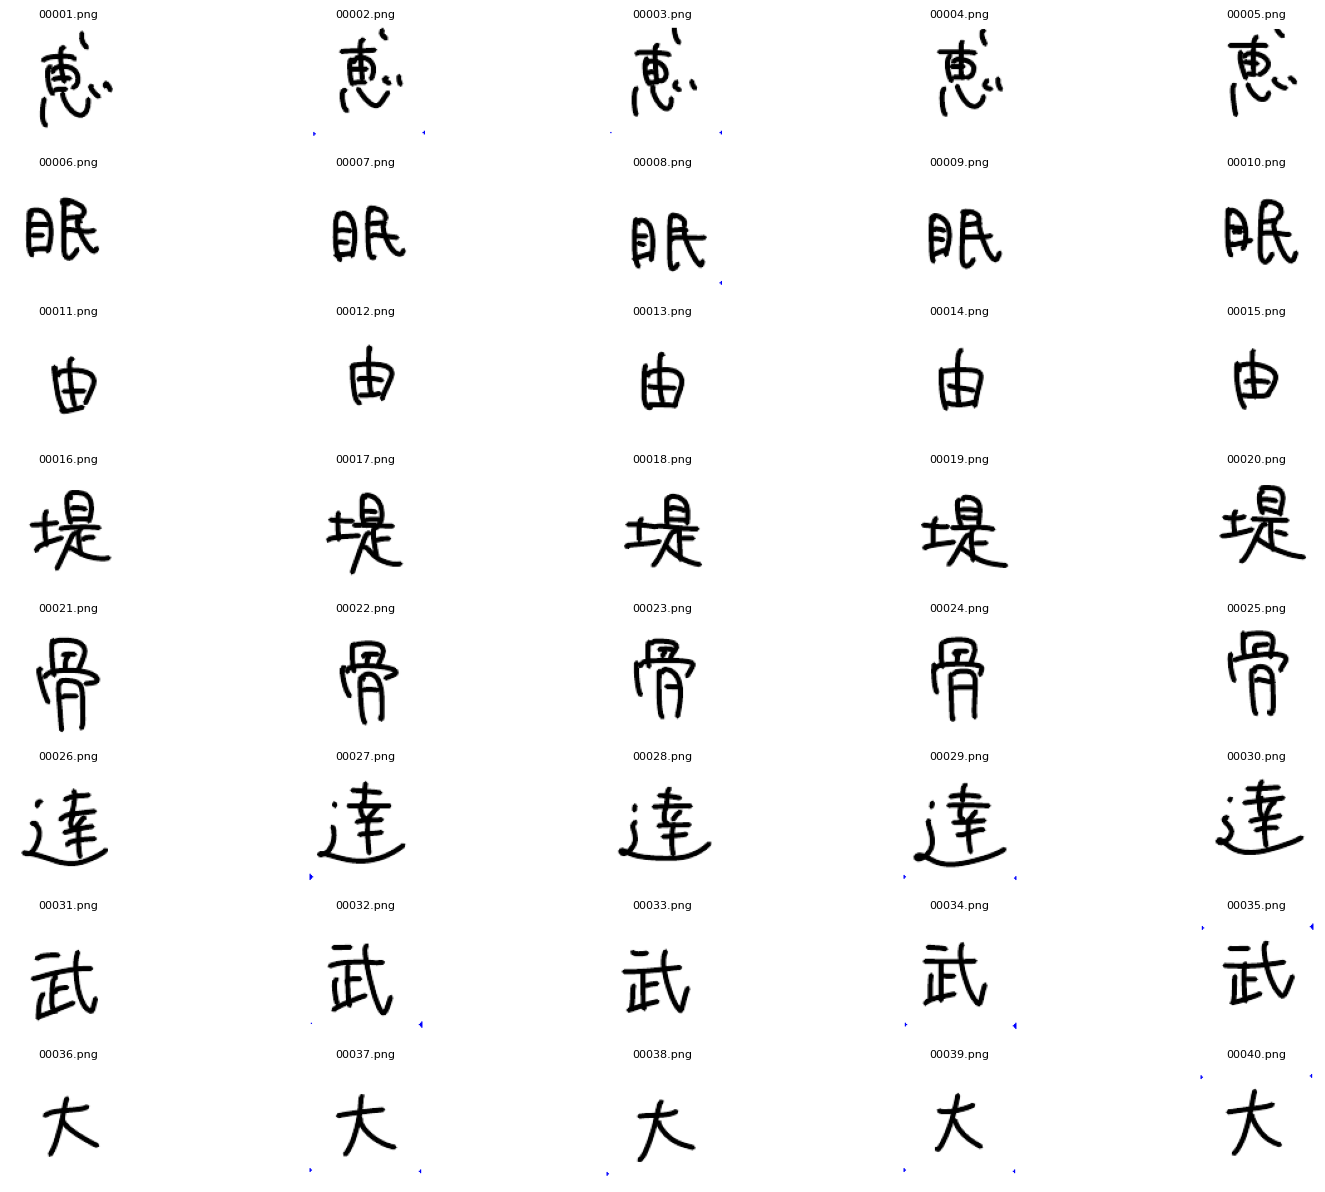

In [29]:
import os
from PIL import Image
import matplotlib.pyplot as plt

def display_images_with_filenames(directory, num_images=50):
    # 指定ディレクトリ内のすべての画像ファイルを取得
    image_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                image_paths.append(os.path.join(root, file))
    
    # 最初の num_images 枚を表示
    selected_images = sorted(image_paths[:num_images])
    
    # 画像を表示
    plt.figure(figsize=(15, 15))
    for i, image_path in enumerate(selected_images):
        image = Image.open(image_path)
        plt.subplot(10, 5, i + 1)  # 10行5列のグリッド
        plt.imshow(image)
        plt.axis('off')
        plt.title(os.path.basename(image_path), fontsize=8)  # ファイル名を表示
    plt.tight_layout()
    plt.show()

directory = '../PRMU/simclr/E_class/0x4fee'
directory = '/data2/abababam1/HandwrittenTextAlign/simclr/tegaki_data/E_char/2/(\'mikami_PRMU_error_char_ver2\', \'.png\')'
display_images_with_filenames(directory)


In [7]:
# 指定された文字列リスト
characters = ['恵', '眼', '曲', '提', '骨', '達', '武', '犬']

# 各文字の16進数の文字コードを取得してリストに変換
def char_list_to_code_list(characters):
    hex_codes = [format(ord(char),'#06x') for char in characters]
    return hex_codes
char_list_to_code_list(characters)

['0x6075',
 '0x63d0',
 '0x66f2',
 '0x6b66',
 '0x72ac',
 '0x773c',
 '0x9054',
 '0x9aa8']

In [15]:
characters = ['恵', '眼', '曲', '提', '骨', '達', '武', '犬']
characters[5:10]

['達', '武', '犬']

In [22]:
import os

# ベースディレクトリ
base_dir = '/data2/abababam1/HandwrittenTextAlign/simclr/tegaki_data/E_char'
for i in ['1', '2', '3']:
    base_subdir = os.path.join(base_dir, i)
    # サブディレクトリごとのファイル数を表示
    subdirs = [os.path.join(base_subdir, d) for d in os.listdir(base_subdir) if os.path.isdir(os.path.join(base_subdir, d))]

    for subdir in subdirs:
        # サブディレクトリ内のファイル数をカウント
        num_files = len([f for f in os.listdir(subdir) if os.path.isfile(os.path.join(subdir, f))])
        print(f"Directory: {subdir}, File Count: {num_files}")

Directory: /data2/abababam1/HandwrittenTextAlign/simclr/tegaki_data/E_char/1/('nosaka-PRMU_error_char', '.png'), File Count: 40
Directory: /data2/abababam1/HandwrittenTextAlign/simclr/tegaki_data/E_char/1/('hattori-PRMU_error_char', '.png'), File Count: 40
Directory: /data2/abababam1/HandwrittenTextAlign/simclr/tegaki_data/E_char/1/('matsuzaki-PRMU_error_char', '.png'), File Count: 40
Directory: /data2/abababam1/HandwrittenTextAlign/simclr/tegaki_data/E_char/1/('mikami_PRMU_error_char_ver', '.png'), File Count: 40
Directory: /data2/abababam1/HandwrittenTextAlign/simclr/tegaki_data/E_char/1/('nagato-PRMU_error_char', '.png'), File Count: 40
Directory: /data2/abababam1/HandwrittenTextAlign/simclr/tegaki_data/E_char/1/('harima-PRMU_error_char', '.png'), File Count: 40
Directory: /data2/abababam1/HandwrittenTextAlign/simclr/tegaki_data/E_char/1/('fujiwara-PRMU_error_char', '.png'), File Count: 40
Directory: /data2/abababam1/HandwrittenTextAlign/simclr/tegaki_data/E_char/1/('yoshida-PRMU_er